In [11]:
import pandas as pd
from darts import TimeSeries
from darts.models import TiDEModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


In [12]:
# 1. Đọc và xử lý dữ liệu
def load_and_process_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df.Date)
    df.set_index('Date', inplace=True)
    return df[['Close']]

btc = load_and_process_data('./Cryptocurrencies/BTC.csv')
eth = load_and_process_data('./Cryptocurrencies/ETH.csv')
doge = load_and_process_data('./Cryptocurrencies/DOGE.csv')


In [13]:
# 2. Chuẩn hóa dữ liệu và tạo dataset
def prepare_data(df, look_back=30):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    
    X, y = [], []
    for i in range(len(df_scaled) - look_back):
        X.append(df_scaled[i:(i+look_back), 0])
        y.append(df_scaled[i + look_back, 0])
    
    X, y = np.array(X), np.array(y)
    
    train_size = int(len(X) * 0.9)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train, X_test, y_test, scaler

In [14]:
# 3. Xây dựng mô hình TiDE
def build_tide_model(input_shape):
    model = TiDEModel(input_chunk_length=input_shape[0], output_chunk_length=1)
    return model

In [15]:

# 4. Huấn luyện mô hình và đánh giá
def train_and_evaluate(model, X_train, y_train, X_test, y_test, scaler):
    series_train = TimeSeries.from_values(y_train.flatten())
    series_test = TimeSeries.from_values(y_test.flatten())
    model.fit(series_train, verbose=True)
    
    pred_test = model.predict(n=len(y_test), series=series_test)
    
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    pred_test_inv = scaler.inverse_transform(pred_test.values().reshape(-1, 1))
    
    mse = mean_squared_error(y_test_inv, pred_test_inv)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_inv, pred_test_inv)
    
    def mean_absolute_scaled_error(y_true, y_pred):
        mae = np.mean(np.abs(y_true - y_pred))
        mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
        return mae / mae_naive
    
    mase = mean_absolute_scaled_error(y_test_inv, pred_test_inv)
    
    return model, pred_test, rmse, mape, mase

In [16]:
# 5. Dự đoán 
def predict_future(model, last_sequence, scaler, days):
    series_last = TimeSeries.from_values(last_sequence.flatten())
    forecast = model.predict(n=days, series=series_last)
    future_prices = scaler.inverse_transform(forecast.values().reshape(-1, 1))
    return future_prices.flatten()


In [17]:
# 6. Xử lý dữ liệu và huấn luyện mô hình cho mỗi loại tiền
results = {}
for coin, df in zip(['BTC', 'ETH', 'DOGE'], [btc, eth, doge]):
    X_train, y_train, X_test, y_test, scaler = prepare_data(df)
    model = build_tide_model((X_train.shape[1], 1))
    model, pred_test, rmse_test, mape_test, mase_test = train_and_evaluate(model, X_train, y_train, X_test, y_test, scaler)
    
    last_sequence = X_test[-1]
    future_predictions = {}
    for days in [30, 60, 90]:
        future_prices = predict_future(model, last_sequence, scaler, days)
        future_predictions[days] = future_prices
    
    results[coin] = {
        'model': model,
        'pred_test': pred_test,
        'rmse_test': rmse_test,
        'mape_test': mape_test,
        'mase_test': mase_test,
        'future_predictions': future_predictions,
        'test_dates': df.index[-len(y_test):],
        'scaler': scaler
    }

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 24.4 K | train
6 | decoders         | Sequential       | 20.6 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 31     | train
--------------------------------------------------------------
45.7 K    Trainable params
0         Non-trainable params
45.7 K    Total params
0.183     Total estimated model params size (MB)


Epoch 0:  29%|██▉       | 16/55 [00:00<00:00, 55.36it/s, train_loss=0.0117] 

Epoch 99: 100%|██████████| 55/55 [00:00<00:00, 71.37it/s, train_loss=0.000373]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 55/55 [00:00<00:00, 69.95it/s, train_loss=0.000373]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.88it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.08it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.15it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 24.4 K | train
6 | decoders         | Sequential       | 20.6 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 31     | train
--------------------------------------------------------------
45.7 K    Trainable params
0         Non-trainable params
45.7 K    Total params
0.183     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 55/55 [00:00<00:00, 78.16it/s, train_loss=0.000221]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 55/55 [00:00<00:00, 77.94it/s, train_loss=0.000221]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.05it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.53it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.38it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 24.4 K | train
6 | decoders         | Sequential       | 20.6 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 31     | train
--------------------------------------------------------------
45.7 K    Trainable params
0         Non-trainable params
45.7 K    Total params
0.183     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 55/55 [00:00<00:00, 77.54it/s, train_loss=0.000208]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 55/55 [00:00<00:00, 77.54it/s, train_loss=0.000208]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.78it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.40it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.62it/s]


In [18]:
# 7. In kết quả đánh giá
for coin in results:
    print(f"{coin} Evaluation:")
    print(f"Test RMSE: {results[coin]['rmse_test']}, MAPE: {results[coin]['mape_test']}, MASE: {results[coin]['mase_test']}")
    print()


BTC Evaluation:
Test RMSE: 36105.86561045862, MAPE: 0.4985481699669097, MASE: 26.094064828611188

ETH Evaluation:
Test RMSE: 0.08986777710331872, MAPE: 0.5154068515772444, MASE: 14.267507103477485

DOGE Evaluation:
Test RMSE: 1212.554930469691, MAPE: 0.41510192415338665, MASE: 16.40377763854502



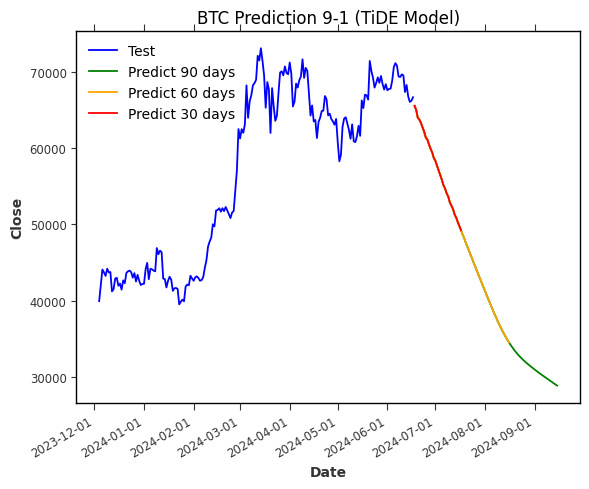

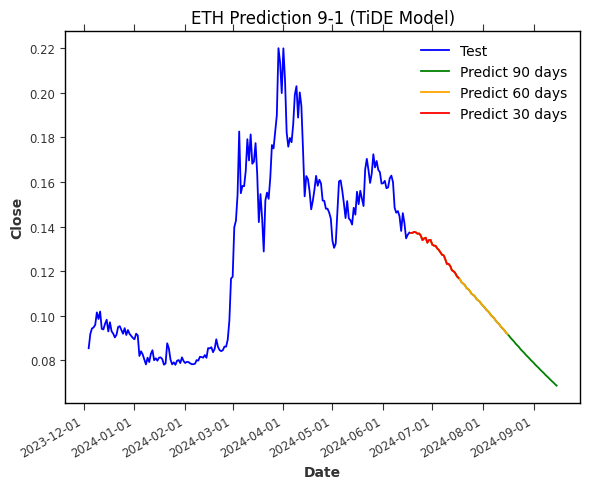

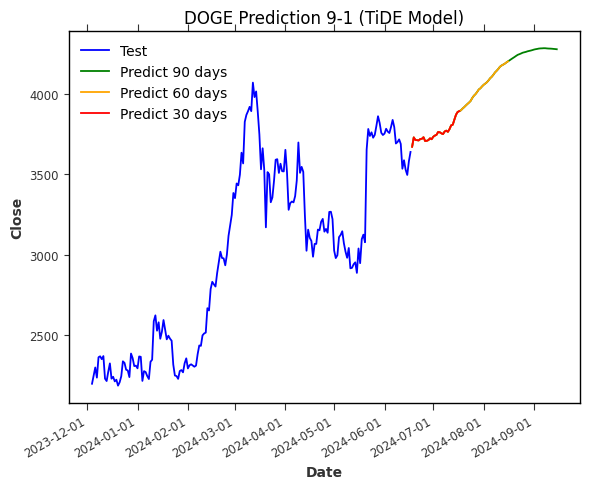

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import os

# Đảm bảo rằng thư mục để lưu ảnh tồn tại
output_dir = 'charts'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

colors = ['green', 'orange', 'red']

def save_chart_and_display(coin, fig):
    # Lưu biểu đồ vào thư mục
    output_file = os.path.join(output_dir, f'{coin}_prediction_9_1.png')
    fig.savefig(output_file)
    
    # Hiển thị biểu đồ trên màn hình
    plt.show()

for coin, data in results.items():
    df = globals()[coin.lower()]
    
    fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
    
    # Plot dữ liệu test
    ax.plot(data['test_dates'], df['Close'][-len(data['pred_test']):], color='blue', label='Test')
    
    # Plot dự đoán cho 90, 60, 30 ngày tiếp theo với màu sắc khác nhau
    last_date = df.index[-1]
    for j, days in enumerate([90, 60, 30]):
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days)
        ax.plot(future_dates, data['future_predictions'][days], color=colors[j], label=f'Predict {days} days')
    
    ax.set_title(f'{coin} Prediction 9-1 (TiDE Model)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close')
    ax.legend()
    
    # Định dạng trục x để hiển thị ngày tháng
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    
    # Xoay và căn chỉnh nhãn của trục x
    plt.gcf().autofmt_xdate()
    
    # Tắt grid
    ax.grid(False)
    
    # Thêm khung viền và các gạch ở trục x
    ax.tick_params(axis='x', which='both', bottom=True, top=True, length=5)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
    plt.tight_layout()
    
    # Lưu và hiển thị biểu đồ
    save_chart_and_display(coin, fig)
